# "Single-column" set for Test 1: Reading ecRad output and computing CRH.

### Test 1: Cloud Temperature (Altitude)

#### Version 7a: 2024-07-25

* This version include logscale colorbar with SymLogNorm
* Temperature range from 236 K to 200 K for cloud middle level.
* Ice Optical Schemes (index associated with config file):
        5.1 Fu 1996 and Fu, Yang & Sun 1998 (1O).
        5.2 Yi et al. 2013 (2O).
        5.3 Baran et al. 2016 (3O).
        5.4 Baran et al. 2014 (4O).

### Loading Libraries

In [1]:
import numpy as np # Version used here: 1.23.4 (python 3.8.15)
import pandas as pd # Version used here: 1.5.2 (python 3.8.15)
import xarray as xr # Version used here: 2022.11.0 (python 3.8.15)
from scipy import interpolate # Version used here: 1.10.0 (python 3.8.15)

import matplotlib.pyplot as plt # Version used here: 3.6.2 (python 3.8.15)
import matplotlib.colors as colors

%matplotlib notebook

## Reading data

### ecRad output data

- 1O: Fu (Fu 1996 / Fu, Yang & Sun 1998)
- 2O: Yi (Yi et al. 2013)
- 3O: Baran2016 (Baran et al. 2016)
- 4O: Baran (Baran et al. 2014)

In [16]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
for opt in range(1,5):
    file = 'output_1D_set_test1_'+str(opt)+'O1S_v7a.nc'
    globals()['ecrad_out_'+str(opt)+'O1S_v7a'] = xr.open_dataset(data_path+file)

### Tropical Profile (to get temperature profile)

In [17]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_17752/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [20]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(ecrad_out_1O1S_v6.pressure_hl.values)

height_int     = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['height (km)'].iloc[::-1])
height_hl      = height_int(ecrad_out_1O1S_v6.pressure_hl.values)

In [30]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

height_hl_pd    = pd.Series(height_hl[0])

### Cloud-radiative Heating (CRH) Rate matrix calculation:

Cloud-radiative Heating (CRH) rate in K d$^{-1}$ for each spectral component i (SW and LW):

$$\text{CRH}_{i} \;\equiv\; - \frac{g_0}{C_P}\frac{d(\text{CRE}_{i})}{dP}\;\;\left[\frac{K}{s}\right]\times\;86400\;\left[\frac{s}{d}\right]$$

where g$_0$ is the gravity acceleration (9.8 m s$^{-2}$), C$_P$ is the specific heat capacity of dry air (1080 J kg$^{-1}$ K$^{-1}$) and CRE$_{i}$ is the Cloud Radiative Effect for each spectral component i (SW and LW), computed as:

$$CRE_{i} \;=\; F_{All_{i}}^{NET} - F_{Clear_{i}}^{NET}$$

where F$^{\text{NET}}$ is the NET irradiance or flux (W m$^{-2}$), computed as:

$$F_{i}^{NET} \;=\; F_{i}^{Downward} - F_{i}^{Upward}$$

Take into account some authors use outgoing fluxes as positive (Be carefull with this).

In [32]:
tempi = ecrad_out_1O1S.sizes['column']     # Temperature Levels
profi = ecrad_out_1O1S.sizes['half_level'] # Vertical Profile

## Heat capacity [J kg^-1 K^-1]:
cp = 1.08*10**(3)
## Volumetric heat capacity as ICON evaluates on model levels, not pl:
# cv = 0.718*10**3
## Gravity [m s^-2]:
g = 9.8

## Heating rates matrices [K day-1]:
H_lw  = np.zeros((4, tempi, profi))
H_sw  = np.zeros((4, tempi, profi))
H_net = np.zeros((4, tempi, profi))

## Matrices for plotting:
H_sw_plot  = np.zeros((4, profi, tempi))
H_lw_plot  = np.zeros((4, profi, tempi))
H_net_plot = np.zeros((4, profi, tempi))

for opt in range(1,5): # per optical scheme
    ecrad_out = eval('ecrad_out_'+str(opt)+'O1S_v7a')
    for i in range(tempi):
        pres = ecrad_out.pressure_hl.values[i] # Pressure [Pa]

        # Net Fluxes [W m-2]
        lw_net_flux_cloudy = ecrad_out.flux_dn_lw.values[i] - ecrad_out.flux_up_lw.values[i]
        lw_net_flux_clear  = ecrad_out.flux_dn_lw_clear.values[i] - ecrad_out.flux_up_lw_clear.values[i]
        sw_net_flux_cloudy = ecrad_out.flux_dn_sw.values[i] - ecrad_out.flux_up_sw.values[i]
        sw_net_flux_clear  = ecrad_out.flux_dn_sw_clear.values[i] - ecrad_out.flux_up_sw_clear.values[i]

        # Cloud Radiative Effect [W m-2]
        lw_cre = lw_net_flux_cloudy - lw_net_flux_clear
        sw_cre = sw_net_flux_cloudy - sw_net_flux_clear

        # The sign is because of the definition of Outgoing fluxes as positive:
        # By using the diff function:
        #H_lw[opt-1,i,:] = -(g/cp)*(np.diff(lw_cre)/np.diff(pres))*86400 # K day^(-1)
        #H_sw[opt-1,i,:] = -(g/cp)*(np.diff(sw_cre)/np.diff(pres))*86400 # K day^(-1)
        # By using the gradient function:
        H_lw[opt-1,i,:] = -(g/cp)*(np.gradient(lw_cre, pres))*86400 # K day^(-1)
        H_sw[opt-1,i,:] = -(g/cp)*(np.gradient(sw_cre, pres))*86400 # K day^(-1)

    H_net[opt-1,:,:] = H_lw[opt-1,:,:] + H_sw[opt-1,:,:]

    # For plotting:
    H_sw_plot[opt-1,:,:]  = np.transpose(H_sw[opt-1,:,:])
    H_lw_plot[opt-1,:,:]  = np.transpose(H_lw[opt-1,:,:])
    H_net_plot[opt-1,:,:] = np.transpose(H_net[opt-1,:,:])

In [94]:
ecrad_out_1O1S_v7a

<xarray.Dataset>
Dimensions:                  (column: 22, half_level: 82)
Dimensions without coordinates: column, half_level
Data variables: (12/13)
    pressure_hl              (column, half_level) float64 5.65e+03 ... 1.013e+05
    flux_up_lw               (column, half_level) float64 154.6 154.5 ... 457.7
    flux_dn_lw               (column, half_level) float64 0.0 1.817 ... 407.3
    flux_up_lw_clear         (column, half_level) float64 289.7 289.7 ... 457.4
    flux_dn_lw_clear         (column, half_level) float64 0.0 1.817 ... 397.1
    flux_up_sw               (column, half_level) float64 225.9 225.8 ... 23.13
    ...                       ...
    flux_dn_direct_sw        (column, half_level) float64 ...
    flux_up_sw_clear         (column, half_level) float64 81.88 81.8 ... 30.1
    flux_dn_sw_clear         (column, half_level) float64 816.6 815.9 ... 602.1
    flux_dn_direct_sw_clear  (column, half_level) float64 ...
    cloud_cover_lw           (column) float64 ...
    cloud_cover_sw           (column) float64 ...
Attributes:
    title:       Radiative flux profiles from the ecRad offline radiation model
    source:      ecRad offline radiation model
    history:     2024-07-23 17:18:46: ./ecrad config_1O1S.nam input_1D_set_te...
    references:  Hogan, R. J., and A. Bozzo, 2018: A flexible and efficient r...
    experiment:  Control

## Figure for SM:

In [41]:
print(H_lw_plot_v7a.max())
print(H_sw_plot_v7a.max())
print(H_net_plot_v7a.max())
print(H_lw_plot_v7a.min())
print(H_sw_plot_v7a.min())
print(H_net_plot_v7a.min())

48.26374677358128
13.161953649981193
52.819262791782826
-10.369691960485852
-0.6960812531738134
-3.968654216357789


For SymLogNorm:

In [57]:
MaxMax = max([H_lw_plot_v7a.max(), H_sw_plot_v7a.max(), H_net_plot_v7a.max(), 
              abs(H_lw_plot_v7a.min()), abs(H_sw_plot_v7a.min()), abs(H_net_plot_v7a.min())])

In [58]:
MaxMax

52.819262791782826

Store this in a function:

In [59]:
pos_tick_list = []
neg_tick_list = []
if MaxMax > 0 and MaxMax < 1:
    MaxMax = MaxMax - (MaxMax % .05) + .05
    if MaxMax % 0.1 == 0: extra = 0
    else: extra = .05
    linthresh = .01
    linscale  = .1
    list01 = np.round(np.linspace(0.02, 0.09, 8), 2)
    list1  = np.round(np.linspace(0.2, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 1)
    pos_tick_list = list(list01) + list(list1)
    neg_tick_list = list(-list1[::-1]) + list(-list01[::-1])
    maj_tickbar = [-0.1, 0, 0.1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 10:
    MaxMax = MaxMax - (MaxMax % .5) + .5
    if MaxMax % 1 == 0: extra = 0
    else: extra = .5
    linthresh = .1
    linscale  = .1
    list1 = np.round(np.linspace(0.1, 0.9, 9), 1)
    list2 = np.round(np.linspace(2, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2)
    neg_tick_list = list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-1, 0, 1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 100:
    MaxMax = MaxMax - (MaxMax % 5) + 5
    if MaxMax % 10 == 0: extra = 0
    else: extra = 5
    linthresh = 1
    linscale  = .1
    #list1 = np.round(np.linspace(0.1, 0.9, 9), 1)
    list2 = np.round(np.linspace(2, 9, 8),2)
    list3 = np.round(np.linspace(20, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list2) + list(list3)
    neg_tick_list = list(-list3[::-1]) + list(-list2[::-1])
    maj_tickbar = [-10, 0, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
else:
    MaxMax = MaxMax - (MaxMax % 10) + 10
    if MaxMax % 10 == 0: extra = 0
    else: extra = .5
    linthresh = 1
    linscale  = .1
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, 9, 8), 2)
    list3 = np.round(np.linspace(20, 90, 8), 2)
    list4 = np.round(np.linspace(200, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2) + list(list3) + list(list4)
    neg_tick_list = list(-list4[::-1]) + list(-list3[::-1]) + list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-10, 0, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra

In [60]:
MaxMax

55.0

In [61]:
vmax

60.0

Max and min lines for each case:

In [62]:
input_dir  = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
input_file = 'input_test1_v7a.nc'

In [63]:
input_qi = xr.open_dataset(input_dir + input_file).q_ice.values.T
# Adding an extra fake number at cloud bottom to avoud half level pressure differences:
for col in range(len(input_qi[0,:])):
    for row in range(len(input_qi[:,0])):
        if input_qi[::-1, col][row] != 0: 
            input_qi[::-1, col][row-1] = 1 
            break
            
sw_ranges  = np.zeros((4, 2)) # min and max
lw_ranges  = np.zeros((4, 2))
net_ranges = np.zeros((4, 2))
for opt in range(4):
    for comp in ['sw','lw','net']:
        eval(comp+'_ranges')[opt, 0] = eval('H_'+comp+'_plot_v7a')[opt,:-1,:].min(where = (input_qi > 0), initial = 100)
        eval(comp+'_ranges')[opt, 1] = eval('H_'+comp+'_plot_v7a')[opt,:-1,:].max(where = (input_qi > 0), initial = -100)

<IPython.core.display.Javascript object>


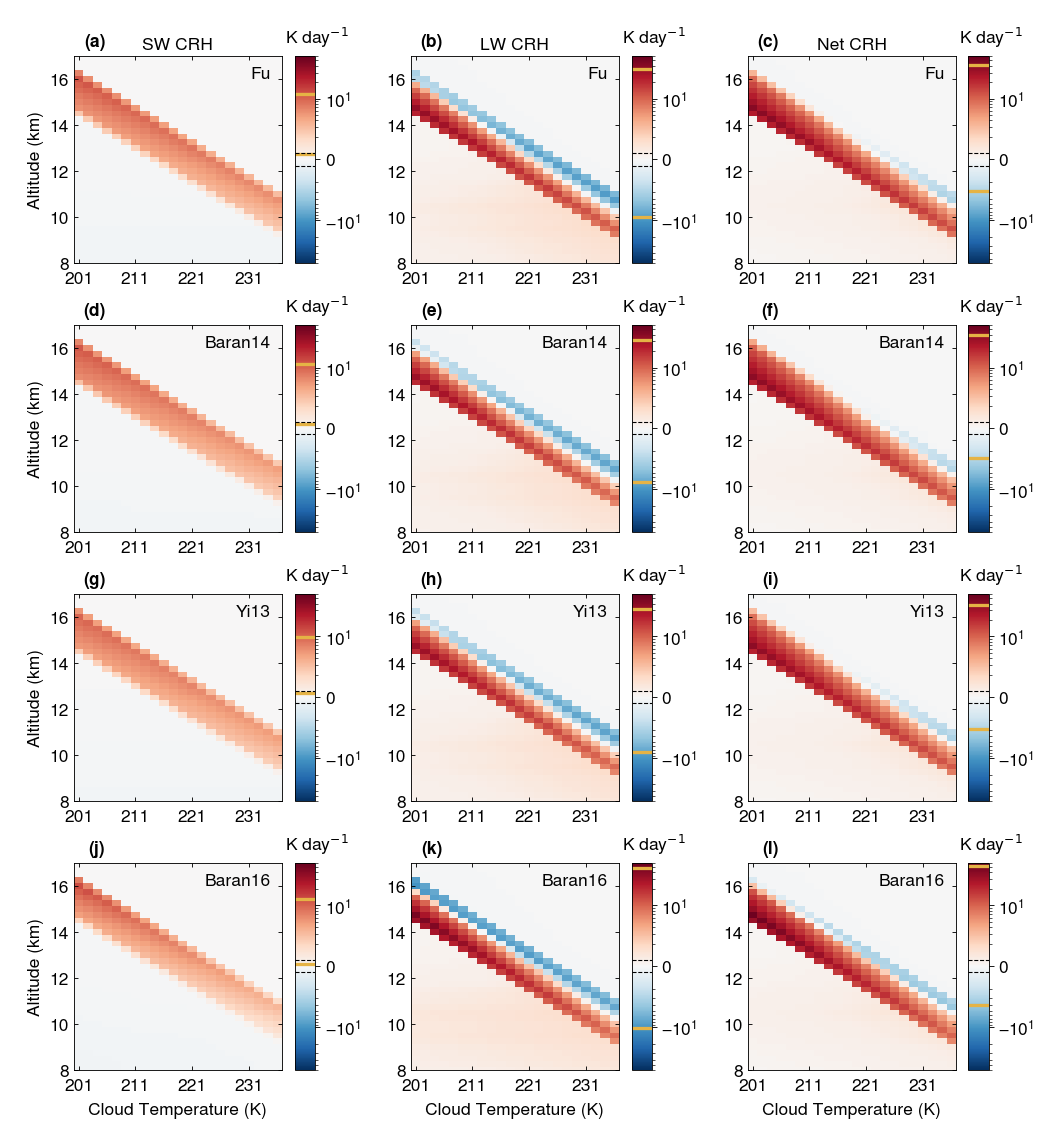

In [64]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 14.5 # inches
flength  = 13.5 # inches

rows    = 4
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.06, left = 0.07, right = 0.95, 
                    hspace = .3, wspace = .3)

# COLORMAPS
labelpad  = -40

Sch_order = [0, 3, 1, 2] # Fu, Baran 2014, Yi and Baran2016
for opt in range(rows):
    sch = Sch_order[opt]
    
    # Shortwave Heating Rate
    im = ax[opt, 0].imshow(H_sw_plot_v7a[sch], cmap = 'RdBu_r', aspect = 'auto',
                           norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                    vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(sw_ranges[sch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(sw_ranges[sch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 0].set_title('SW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[opt, 1].imshow(H_lw_plot_v7a[sch], cmap = 'RdBu_r', aspect = 'auto', 
                           norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                    vmin = vmin, vmax = vmax))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(lw_ranges[sch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(lw_ranges[sch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 1].set_title('LW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[opt, 2].imshow(H_net_plot_v7a[sch], cmap = 'RdBu_r', aspect = 'auto',
                           norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                    vmin = vmin, vmax = vmax))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(net_ranges[sch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(net_ranges[sch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 2].set_title('Net CRH', color ='black',
                             fontsize = fontsize, fontname = fontname)

# AXIS PARAMETERS
# Y Axis: altitude tickLabels are rounded for visualization:
yticks      = np.arange(0, H_net_v7a.shape[2]+1, 8) # altitude tick labels
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 24, 6)
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()
    
OptSch          = ['Fu', 'Yi13', 'Baran16', 'Baran14']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
panel_letters_i = 0
for opt in range(rows):
    sch = Sch_order[opt]
    for j in range(columns):
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        if opt == 3:
            ax[opt, j].set_xlabel(r'Cloud Temperature (K)', 
                                  fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 7.5)
        ax[opt, j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 7.5)
        for tick in ax[opt, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_xticks(xticks)
        ax[opt, j].set_xticklabels(xticklabels) #[::-1]
        ax[opt, j].tick_params(axis = 'y', which = 'major', color = 'black',
                               size = 4, direction = 'in', right = True,
                               labelsize = fontsize, pad = 5)
        for tick in ax[opt, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_yticks(yticks)
        ax[opt, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[opt, j].set_ylabel('Altitude (km)', fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 5)
        ax[opt, j].text(0.95, 0.95, OptSch[sch],
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')

        ax[opt, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        
        # Panel letters:
        ax[opt, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/paper_figures/')
#plt.savefig(out_dir+'crh_test1_S4_v6alt.pdf', dpi=500)

## Comparison between gases and no gases:

In [67]:
H_lw_plot_gas_diff = H_lw_plot_v7a - H_lw_plot_v6
H_sw_plot_gas_diff = H_sw_plot_v7a - H_sw_plot_v6
H_net_plot_gas_diff = H_net_plot_v7a - H_net_plot_v6

In [68]:
print(H_lw_plot_gas_diff.max())
print(H_sw_plot_gas_diff.max())
print(H_net_plot_gas_diff.max())
print(H_lw_plot_gas_diff.min())
print(H_sw_plot_gas_diff.min())
print(H_net_plot_gas_diff.min())

1.0435180496966865
0.0865138614472688
0.8118940756051378
-10.969787785636058
-0.513236544714216
-11.19674215476197


For SymLogNorm:

In [83]:
MaxMax = max([H_lw_plot_gas_diff.max(), H_sw_plot_gas_diff.max(), H_net_plot_gas_diff.max(), 
              abs(H_lw_plot_gas_diff.min()), abs(H_sw_plot_gas_diff.min()), abs(H_net_plot_gas_diff.min())])

In [84]:
MaxMax

11.19674215476197

In [85]:
pos_tick_list = []
neg_tick_list = []
if MaxMax > 0 and MaxMax < 1:
    MaxMax = MaxMax - (MaxMax % .05) + .05
    if MaxMax % 0.1 == 0: extra = 0
    else: extra = .05
    linthresh = .01
    linscale  = .1
    list01 = np.round(np.linspace(0.02, 0.09, 8), 2)
    list1  = np.round(np.linspace(0.2, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 1)
    pos_tick_list = list(list01) + list(list1)
    neg_tick_list = list(-list1[::-1]) + list(-list01[::-1])
    maj_tickbar = [-0.1, 0, 0.1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 10:
    MaxMax = MaxMax - (MaxMax % .5) + .5
    if MaxMax % 1 == 0: extra = 0
    else: extra = .5
    linthresh = .1
    linscale  = .1
    list1 = np.round(np.linspace(0.1, 0.9, 9), 1)
    list2 = np.round(np.linspace(2, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2)
    neg_tick_list = list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-1, 0, 1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 100:
    MaxMax = MaxMax - (MaxMax % 5) + 5
    if MaxMax % 10 == 0: extra = 0
    else: extra = 5
    linthresh = 1
    linscale  = .1
    #list1 = np.round(np.linspace(0.1, 0.9, 9), 1)
    list2 = np.round(np.linspace(2, 9, 8),2)
    list3 = np.round(np.linspace(20, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list2) + list(list3)
    neg_tick_list = list(-list3[::-1]) + list(-list2[::-1])
    maj_tickbar = [-10, 0, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
else:
    MaxMax = MaxMax - (MaxMax % 10) + 10
    if MaxMax % 10 == 0: extra = 0
    else: extra = .5
    linthresh = 1
    linscale  = .1
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, 9, 8), 2)
    list3 = np.round(np.linspace(20, 90, 8), 2)
    list4 = np.round(np.linspace(200, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2) + list(list3) + list(list4)
    neg_tick_list = list(-list4[::-1]) + list(-list3[::-1]) + list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-10, 0, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra

In [86]:
MaxMax

15.0

In [87]:
vmin

-20.0

Max and min lines for each case:

In [88]:
input_dir  = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
input_file = 'input_test1_v7a.nc'

In [89]:
input_qi = xr.open_dataset(input_dir + input_file).q_ice.values.T
# Adding an extra fake number at cloud bottom to avoud half level pressure differences:
for col in range(len(input_qi[0,:])):
    for row in range(len(input_qi[:,0])):
        if input_qi[::-1, col][row] != 0: 
            input_qi[::-1, col][row-1] = 1 
            break
            
sw_ranges  = np.zeros((4, 2)) # min and max
lw_ranges  = np.zeros((4, 2))
net_ranges = np.zeros((4, 2))
for opt in range(4):
    for comp in ['sw','lw','net']:
        eval(comp+'_ranges')[opt, 0] = eval('H_'+comp+'_plot_gas_diff')[opt,:-1,:].min(where = (input_qi > 0), initial = 100)
        eval(comp+'_ranges')[opt, 1] = eval('H_'+comp+'_plot_gas_diff')[opt,:-1,:].max(where = (input_qi > 0), initial = -100)

<IPython.core.display.Javascript object>


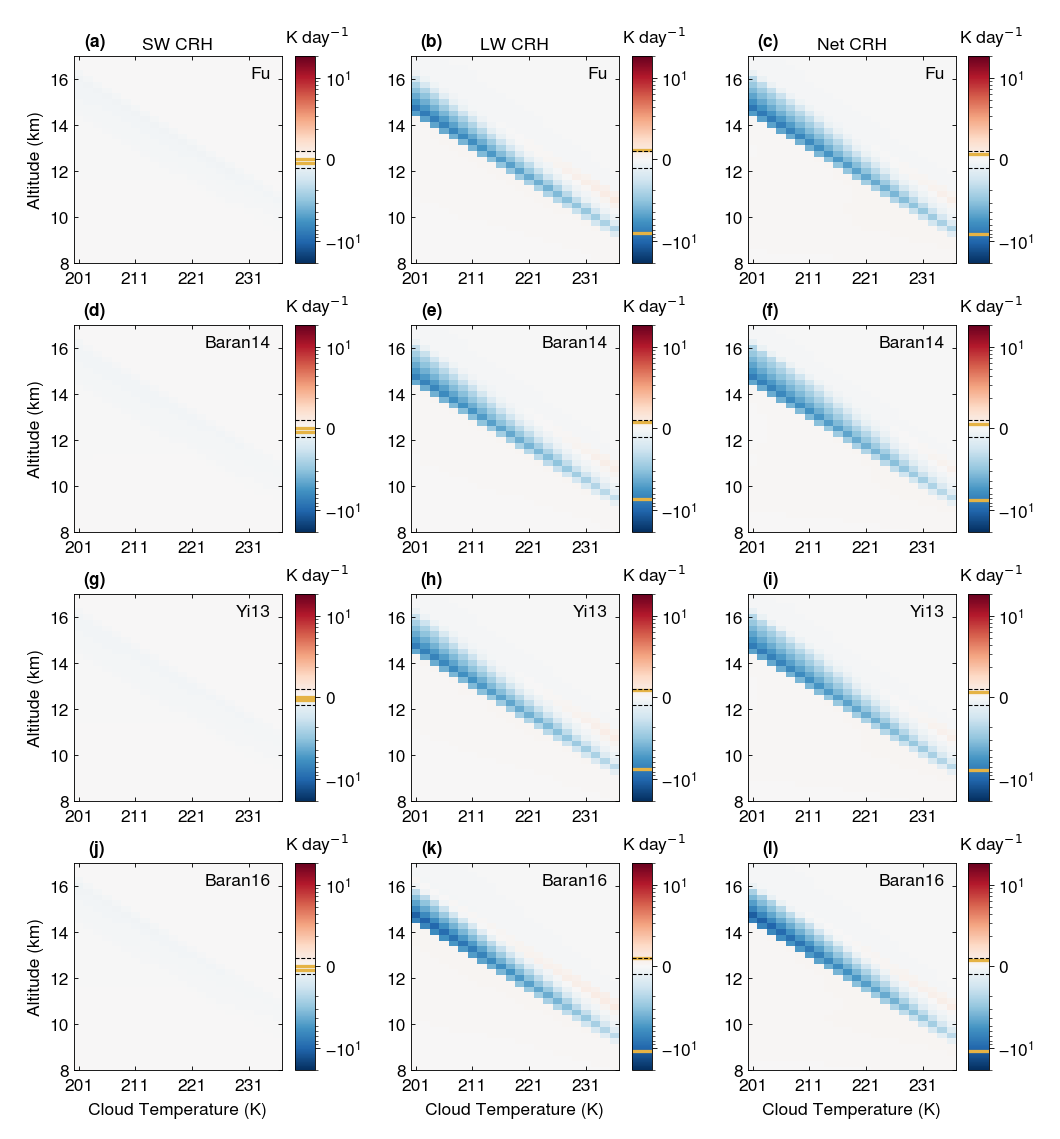

In [90]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 14.5 # inches
flength  = 13.5 # inches

rows    = 4
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.06, left = 0.07, right = 0.95, 
                    hspace = .3, wspace = .3)

# COLORMAPS
labelpad  = -40

Sch_order = [0, 3, 1, 2] # Fu, Baran 2014, Yi and Baran2016
for opt in range(rows):
    sch = Sch_order[opt]
    
    # Shortwave Heating Rate
    im = ax[opt, 0].imshow(H_sw_plot_gas_diff[sch], cmap = 'RdBu_r', aspect = 'auto',
                           norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                    vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(sw_ranges[sch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(sw_ranges[sch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 0].set_title('SW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[opt, 1].imshow(H_lw_plot_gas_diff[sch], cmap = 'RdBu_r', aspect = 'auto', 
                           norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                    vmin = vmin, vmax = vmax))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(lw_ranges[sch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(lw_ranges[sch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 1].set_title('LW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[opt, 2].imshow(H_net_plot_gas_diff[sch], cmap = 'RdBu_r', aspect = 'auto',
                           norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                    vmin = vmin, vmax = vmax))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(net_ranges[sch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(net_ranges[sch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 2].set_title('Net CRH', color ='black',
                             fontsize = fontsize, fontname = fontname)

# AXIS PARAMETERS
# Y Axis: altitude tickLabels are rounded for visualization:
yticks      = np.arange(0, H_net_v7a.shape[2]+1, 8) # altitude tick labels
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 24, 6)
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()
    
OptSch          = ['Fu', 'Yi13', 'Baran16', 'Baran14']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
panel_letters_i = 0
for opt in range(rows):
    sch = Sch_order[opt]
    for j in range(columns):
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        if opt == 3:
            ax[opt, j].set_xlabel(r'Cloud Temperature (K)', 
                                  fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 7.5)
        ax[opt, j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 7.5)
        for tick in ax[opt, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_xticks(xticks)
        ax[opt, j].set_xticklabels(xticklabels) #[::-1]
        ax[opt, j].tick_params(axis = 'y', which = 'major', color = 'black',
                               size = 4, direction = 'in', right = True,
                               labelsize = fontsize, pad = 5)
        for tick in ax[opt, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_yticks(yticks)
        ax[opt, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[opt, j].set_ylabel('Altitude (km)', fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 5)
        ax[opt, j].text(0.95, 0.95, OptSch[sch],
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')

        ax[opt, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        
        # Panel letters:
        ax[opt, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/paper_figures/')
#plt.savefig(out_dir+'crh_test1_S4_v6alt.pdf', dpi=500)

## Figure 2 in paper (CRH interscheme difference):

In [91]:
# Shortwave:
H_sw_diff_plot_v7a    = np.zeros((3, profi, tempi))
H_sw_diff_plot_v7a[0] = H_sw_plot_v7a[1] - H_sw_plot_v7a[0] # Yi - Fu
H_sw_diff_plot_v7a[1] = H_sw_plot_v7a[2] - H_sw_plot_v7a[0] # Baran2016 - Fu
H_sw_diff_plot_v7a[2] = H_sw_plot_v7a[3] - H_sw_plot_v7a[0] # Baran2014 - Fu

# Longwave:
H_lw_diff_plot_v7a    = np.zeros((3, profi, tempi))
H_lw_diff_plot_v7a[0] = H_lw_plot_v7a[1] - H_lw_plot_v7a[0] # Yi - Fu
H_lw_diff_plot_v7a[1] = H_lw_plot_v7a[2] - H_lw_plot_v7a[0] # Baran2016 - Fu
H_lw_diff_plot_v7a[2] = H_lw_plot_v7a[3] - H_lw_plot_v7a[0] # Baran2014 - Fu

# Net:
H_net_diff_plot_v7a    = np.zeros((3, profi, tempi))
H_net_diff_plot_v7a[0] = H_net_plot_v7a[1] - H_net_plot_v7a[0] # Yi - Fu
H_net_diff_plot_v7a[1] = H_net_plot_v7a[2] - H_net_plot_v7a[0] # Baran - Fu
H_net_diff_plot_v7a[2] = H_net_plot_v7a[3] - H_net_plot_v7a[0] # Baran - Fu

In [92]:
# Shortwave CRH differences:
print('Shortwave CRH Differences:')
print('Yi - Fu max: ',H_sw_diff_plot_v7a[0].max())
print('Yi - Fu min: ',H_sw_diff_plot_v7a[0].min())
print('Baran2016 - Fu max: ',H_sw_diff_plot_v7a[1].max())
print('Baran2016 - Fu min: ',H_sw_diff_plot_v7a[1].min())
print('Baran2014 - Fu max: ',H_sw_diff_plot_v7a[2].max())
print('Baran2014 - Fu min: ',H_sw_diff_plot_v7a[2].min())

print('')
# Longwave CRH differences:
print('Longwave CRH Differences:')
print('Yi - Fu max: ',H_lw_diff_plot_v7a[0].max())
print('Yi - Fu min: ',H_lw_diff_plot_v7a[0].min())
print('Baran2016 - Fu max: ',H_lw_diff_plot_v7a[1].max())
print('Baran2016 - Fu min: ',H_lw_diff_plot_v7a[1].min())
print('Baran2014 - Fu max: ',H_lw_diff_plot_v7a[2].max())
print('Baran2014 - Fu min: ',H_lw_diff_plot_v7a[2].min())

print('')
# Net CRH differences:
print('Net CRH Differences:')
print('Yi - Fu max: ',H_net_diff_plot_v7a[0].max())
print('Yi - Fu min: ',H_net_diff_plot_v7a[0].min())
print('Baran2016 - Fu max: ',H_net_diff_plot_v7a[1].max())
print('Baran2016 - Fu min: ',H_net_diff_plot_v7a[1].min())
print('Baran2014 - Fu max: ',H_net_diff_plot_v7a[2].max())
print('Baran2014 - Fu min: ',H_net_diff_plot_v7a[2].min())

Shortwave CRH Differences:
Yi - Fu max:  0.07604998379710282
Yi - Fu min:  -2.1866775093434754
Baran2016 - Fu max:  1.1842701660573507
Baran2016 - Fu min:  -2.392892046750839
Baran2014 - Fu max:  0.3434018731079078
Baran2014 - Fu min:  -1.0081215797522782

Longwave CRH Differences:
Yi - Fu max:  1.2747909086924145
Yi - Fu min:  -3.004534379418338
Baran2016 - Fu max:  12.90058940658195
Baran2016 - Fu min:  -7.765855524104158
Baran2014 - Fu max:  1.5995929502092232
Baran2014 - Fu min:  -2.8203834777984156

Net CRH Differences:
Yi - Fu max:  0.06202475913295291
Yi - Fu min:  -3.589512627066391
Baran2016 - Fu max:  11.78952073740924
Baran2016 - Fu min:  -6.581585358046807
Baran2014 - Fu max:  1.1702045313485794
Baran2014 - Fu min:  -2.5348129751458472


For SymLogNorm:

In [98]:
MaxMax = max([H_sw_diff_plot_v7a.max(), H_lw_diff_plot_v7a.max(), H_net_diff_plot_v7a.max(),
              abs(H_sw_diff_plot_v7a.min()), abs(H_lw_diff_plot_v7a.min()), abs(H_net_diff_plot_v7a.min())])

In [99]:
MaxMax

12.90058940658195

Store this in a function:

In [100]:
pos_tick_list = []
neg_tick_list = []
if MaxMax > 0 and MaxMax < 1:
    MaxMax = MaxMax - (MaxMax % .05) + .05
    if MaxMax % 0.1 == 0: extra = 0
    else: extra = .05
    linthresh = .01
    linscale  = .1
    list01 = np.round(np.linspace(0.02, 0.09, 8), 2)
    list1  = np.round(np.linspace(0.2, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 1)
    pos_tick_list = list(list01) + list(list1)
    neg_tick_list = list(-list1[::-1]) + list(-list01[::-1])
    maj_tickbar = [-0.1, 0, 0.1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 10:
    MaxMax = MaxMax - (MaxMax % .5) + .5
    if MaxMax % 1 == 0: extra = 0
    else: extra = .5
    linthresh = .1
    linscale  = .1
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2)
    neg_tick_list = list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-1, 0, 1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 100:
    MaxMax = MaxMax - (MaxMax % 5) + 5
    if MaxMax % 10 == 0: extra = 0
    else: extra = 5
    linthresh = .1
    linscale  = .25
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, 9, 8),2)
    list3 = np.round(np.linspace(20, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2) + list(list3)
    neg_tick_list = list(-list3[::-1]) + list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-10, -1, 0, 1, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
else:
    MaxMax = MaxMax - (MaxMax % 10) + 10
    if MaxMax % 10 == 0: extra = 0
    else: extra = .5
    linthresh = 1
    linscale  = .1
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, 9, 8), 2)
    list3 = np.round(np.linspace(20, 90, 8), 2)
    list4 = np.round(np.linspace(200, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2) + list(list3) + list(list4)
    neg_tick_list = list(-list4[::-1]) + list(-list3[::-1]) + list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-10, 0, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra

In [101]:
input_qi = xr.open_dataset(input_dir + input_file).q_ice.values.T
# Adding an extra fake number at cloud bottom to avoud half level pressure differences:
for col in range(len(input_qi[0,:])):
    for row in range(len(input_qi[:,0])):
        if input_qi[::-1, col][row] != 0: 
            input_qi[::-1, col][row-1] = 1 
            break
            
sw_ranges  = np.zeros((3, 2)) # min and max
lw_ranges  = np.zeros((3, 2))
net_ranges = np.zeros((3, 2))
for opt in range(3):
    for comp in ['sw','lw','net']:
        eval(comp+'_ranges')[opt, 0] = eval('H_'+comp+'_diff_plot_v7a')[opt,:-1,:].min(where = (input_qi > 0), initial = 100)
        eval(comp+'_ranges')[opt, 1] = eval('H_'+comp+'_diff_plot_v7a')[opt,:-1,:].max(where = (input_qi > 0), initial = -100)

<IPython.core.display.Javascript object>


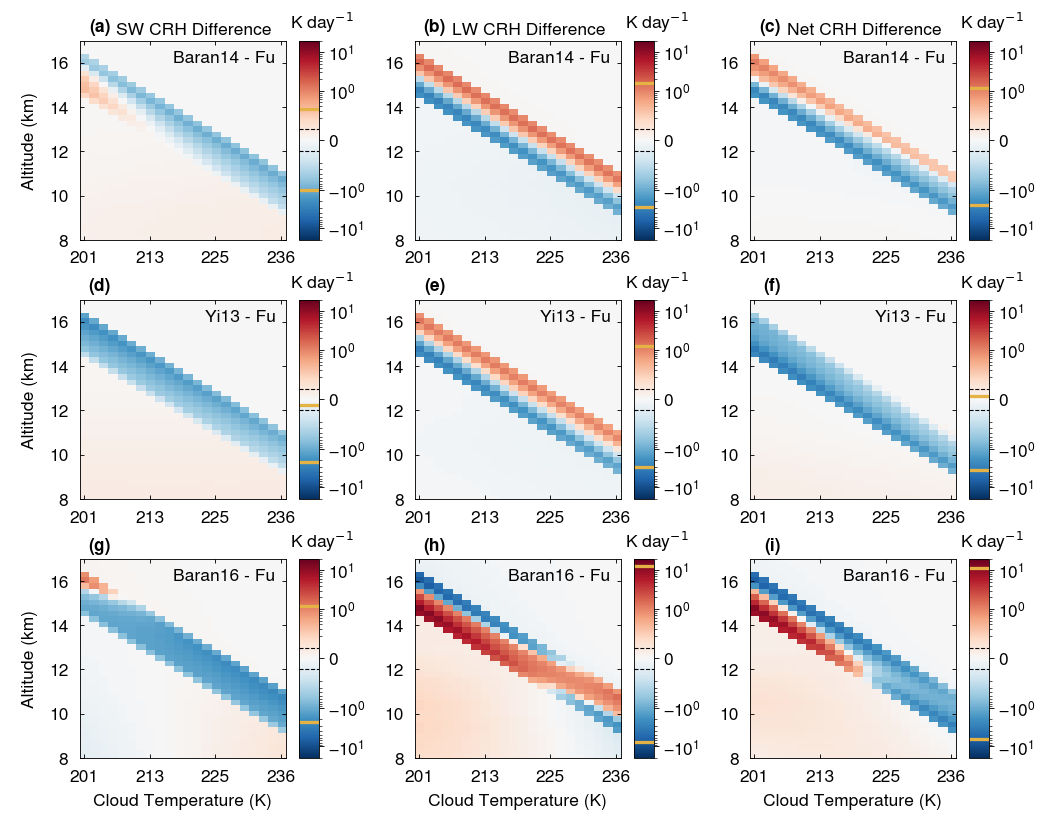

In [102]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 10.5 # inches
flength  = 13.5 # inches

rows    = 3
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.075, right = 0.95, 
                    hspace = .3, wspace = .3)

labelpad  = -40
IntSch_order = [2, 0, 1] # Baran2014 - Fu, Yi - Fu and Baran2016 - Fu

for diff in range(rows): 
    IntSch = IntSch_order[diff]
    
    # Shortwave Heating Rate Difference
    im = ax[diff, 0].imshow(H_sw_diff_plot_v7a[IntSch], cmap = "RdBu_r", aspect = 'auto',
                            norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                     vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(sw_ranges[IntSch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(sw_ranges[IntSch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title('SW CRH Difference', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[diff, 1].imshow(H_lw_diff_plot_v7a[IntSch], cmap = "RdBu_r", aspect = 'auto', 
                            norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                     vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(lw_ranges[IntSch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(lw_ranges[IntSch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title('LW CRH Difference', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[diff, 2].imshow(H_net_diff_plot_v7a[IntSch], cmap = "RdBu_r", aspect = 'auto',
                            norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                     vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(net_ranges[IntSch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(net_ranges[IntSch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 2].set_title('Net CRH Difference', color ='black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)

        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H_net.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff            = ['Yi13 - Fu', 'Baran16 - Fu', 'Baran14 - Fu']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for diff in range(rows):
    IntSch = IntSch_order[diff]
    for j in range(columns):
        if diff == 2:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Altitude (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
        ax[diff, j].text(0.95, 0.95, Diff[IntSch],
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/paper_figures/')
#plt.savefig(out_dir+'crh_diff_test1_Fu_F2_v6alt.pdf', dpi=500)

## Figure 2 comparison between gases and no gas:

In [103]:
# Shortwave:
H_sw_diff_plot_v6    = np.zeros((3, profi, tempi))
H_sw_diff_plot_v6[0] = H_sw_plot_v6[1] - H_sw_plot_v6[0] # Yi - Fu
H_sw_diff_plot_v6[1] = H_sw_plot_v6[2] - H_sw_plot_v6[0] # Baran2016 - Fu
H_sw_diff_plot_v6[2] = H_sw_plot_v6[3] - H_sw_plot_v6[0] # Baran2014 - Fu

# Longwave:
H_lw_diff_plot_v6    = np.zeros((3, profi, tempi))
H_lw_diff_plot_v6[0] = H_lw_plot_v6[1] - H_lw_plot_v6[0] # Yi - Fu
H_lw_diff_plot_v6[1] = H_lw_plot_v6[2] - H_lw_plot_v6[0] # Baran2016 - Fu
H_lw_diff_plot_v6[2] = H_lw_plot_v6[3] - H_lw_plot_v6[0] # Baran2014 - Fu

# Net:
H_net_diff_plot_v6    = np.zeros((3, profi, tempi))
H_net_diff_plot_v6[0] = H_net_plot_v6[1] - H_net_plot_v6[0] # Yi - Fu
H_net_diff_plot_v6[1] = H_net_plot_v6[2] - H_net_plot_v6[0] # Baran - Fu
H_net_diff_plot_v6[2] = H_net_plot_v6[3] - H_net_plot_v6[0] # Baran - Fu

In [104]:
H_lw_odiff_gdiff  = H_lw_diff_plot_v7a - H_lw_diff_plot_v6
H_sw_odiff_gdiff  = H_sw_diff_plot_v7a - H_sw_diff_plot_v6
H_net_odiff_gdiff = H_net_diff_plot_v7a - H_net_diff_plot_v6

In [106]:
# Shortwave CRH differences:
print('Shortwave CRH Differences (gases - no gas):')
print('Yi - Fu max: ',H_sw_odiff_gdiff[0].max())
print('Yi - Fu min: ',H_sw_odiff_gdiff[0].min())
print('Baran2016 - Fu max: ',H_sw_odiff_gdiff[1].max())
print('Baran2016 - Fu min: ',H_sw_odiff_gdiff[1].min())
print('Baran2014 - Fu max: ',H_sw_odiff_gdiff[2].max())
print('Baran2014 - Fu min: ',H_sw_odiff_gdiff[2].min())

print('')
# Longwave CRH differences:
print('Longwave CRH Differences (gases - no gas):')
print('Yi - Fu max: ',H_lw_odiff_gdiff[0].max())
print('Yi - Fu min: ',H_lw_odiff_gdiff[0].min())
print('Baran2016 - Fu max: ',H_lw_odiff_gdiff[1].max())
print('Baran2016 - Fu min: ',H_lw_odiff_gdiff[1].min())
print('Baran2014 - Fu max: ',H_lw_odiff_gdiff[2].max())
print('Baran2014 - Fu min: ',H_lw_odiff_gdiff[2].min())

print('')
# Net CRH differences:
print('Net CRH Differences (gases - no gas):')
print('Yi - Fu max: ',H_net_odiff_gdiff[0].max())
print('Yi - Fu min: ',H_net_odiff_gdiff[0].min())
print('Baran2016 - Fu max: ',H_net_odiff_gdiff[1].max())
print('Baran2016 - Fu min: ',H_net_odiff_gdiff[1].min())
print('Baran2014 - Fu max: ',H_net_odiff_gdiff[2].max())
print('Baran2014 - Fu min: ',H_net_odiff_gdiff[2].min())

Shortwave CRH Differences (gases - no gas):
Yi - Fu max:  0.10422558823333894
Yi - Fu min:  -0.03540233158002337
Baran2016 - Fu max:  0.12536008883797445
Baran2016 - Fu min:  -0.04300958442198066
Baran2014 - Fu max:  0.08985868064916414
Baran2014 - Fu min:  -0.03125008881882163

Longwave CRH Differences (gases - no gas):
Yi - Fu max:  0.4879878848718562
Yi - Fu min:  -0.21470836599137533
Baran2016 - Fu max:  1.0196474720154693
Baran2016 - Fu min:  -3.13118824326979
Baran2014 - Fu max:  0.7887254103360277
Baran2014 - Fu min:  -0.2840692844549415

Net CRH Differences (gases - no gas):
Yi - Fu max:  0.4864943880361281
Yi - Fu min:  -0.11048277775803683
Baran2016 - Fu max:  0.9766378875934887
Baran2016 - Fu min:  -3.1048076089321626
Baran2014 - Fu max:  0.7784032318475127
Baran2014 - Fu min:  -0.2026950124115423


For SymLogNorm:

In [127]:
MaxMax = max([H_sw_odiff_gdiff.max(), H_lw_odiff_gdiff.max(), H_net_odiff_gdiff.max(),
              abs(H_sw_odiff_gdiff.min()), abs(H_lw_odiff_gdiff.min()), abs(H_net_odiff_gdiff.min())])

In [128]:
MaxMax

3.13118824326979

Store this in a function:

In [129]:
pos_tick_list = []
neg_tick_list = []
if MaxMax > 0 and MaxMax < 1:
    MaxMax = MaxMax - (MaxMax % .05) + .05
    if MaxMax % 0.1 == 0: extra = 0
    else: extra = .05
    linthresh = .01
    linscale  = .1
    list01 = np.round(np.linspace(0.02, 0.09, 8), 2)
    list1  = np.round(np.linspace(0.2, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 1)
    pos_tick_list = list(list01) + list(list1)
    neg_tick_list = list(-list1[::-1]) + list(-list01[::-1])
    maj_tickbar = [-0.1, 0, 0.1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 10:
    MaxMax = MaxMax - (MaxMax % .5) + .5
    if MaxMax % 1 == 0: extra = 0
    else: extra = .5
    linthresh = .1
    linscale  = .1
    list01 = np.round(np.linspace(0.02, 0.09, 8), 2)
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, MaxMax + extra, int((MaxMax + extra) - 1)), 2)
    pos_tick_list = list(list1) + list(list2)
    neg_tick_list = list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-1, 0, 1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 100:
    MaxMax = MaxMax - (MaxMax % 5) + 5
    if MaxMax % 10 == 0: extra = 0
    else: extra = 5
    linthresh = .1
    linscale  = .25
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, 9, 8),2)
    list3 = np.round(np.linspace(20, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2) + list(list3)
    neg_tick_list = list(-list3[::-1]) + list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-10, -1, 0, 1, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
else:
    MaxMax = MaxMax - (MaxMax % 10) + 10
    if MaxMax % 10 == 0: extra = 0
    else: extra = .5
    linthresh = 1
    linscale  = .1
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, 9, 8), 2)
    list3 = np.round(np.linspace(20, 90, 8), 2)
    list4 = np.round(np.linspace(200, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2) + list(list3) + list(list4)
    neg_tick_list = list(-list4[::-1]) + list(-list3[::-1]) + list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-10, 0, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra

In [130]:
input_qi = xr.open_dataset(input_dir + input_file).q_ice.values.T
# Adding an extra fake number at cloud bottom to avoud half level pressure differences:
for col in range(len(input_qi[0,:])):
    for row in range(len(input_qi[:,0])):
        if input_qi[::-1, col][row] != 0: 
            input_qi[::-1, col][row-1] = 1 
            break
            
sw_ranges  = np.zeros((3, 2)) # min and max
lw_ranges  = np.zeros((3, 2))
net_ranges = np.zeros((3, 2))
for opt in range(3):
    for comp in ['sw','lw','net']:
        eval(comp+'_ranges')[opt, 0] = eval('H_'+comp+'_odiff_gdiff')[opt,:-1,:].min(where = (input_qi > 0), initial = 100)
        eval(comp+'_ranges')[opt, 1] = eval('H_'+comp+'_odiff_gdiff')[opt,:-1,:].max(where = (input_qi > 0), initial = -100)

<IPython.core.display.Javascript object>


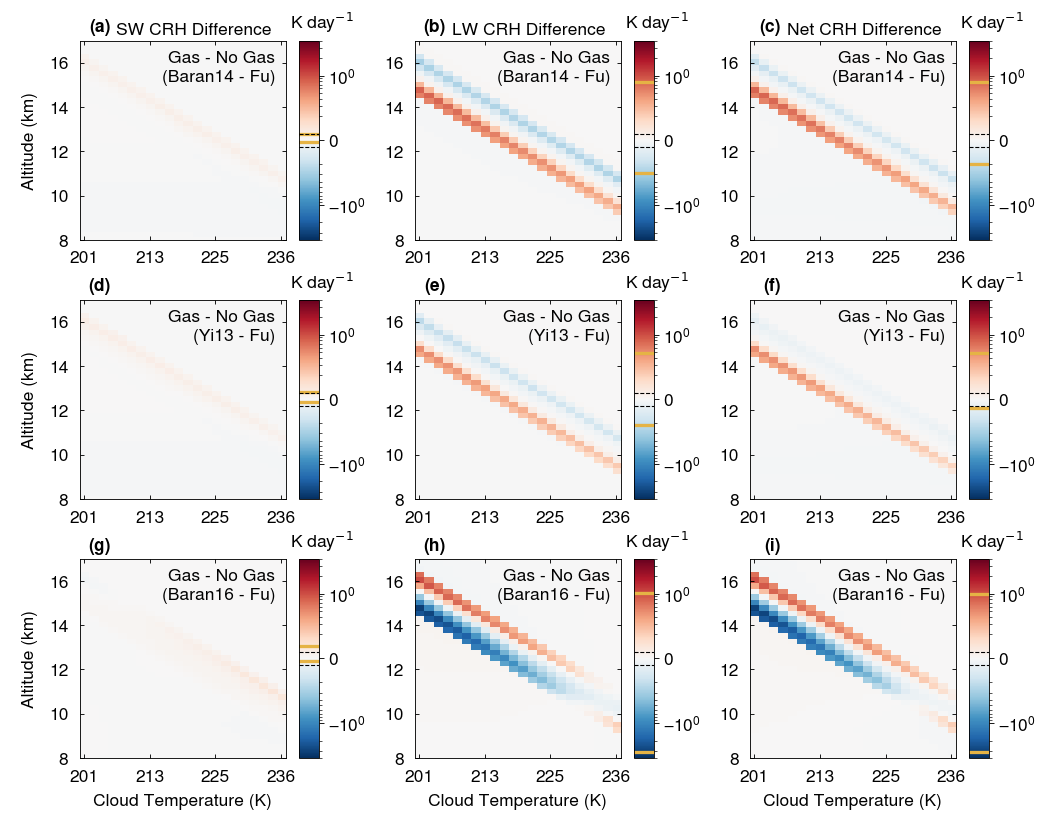

In [133]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 10.5 # inches
flength  = 13.5 # inches

rows    = 3
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.075, right = 0.95, 
                    hspace = .3, wspace = .3)

labelpad  = -40
IntSch_order = [2, 0, 1] # Baran2014 - Fu, Yi - Fu and Baran2016 - Fu

for diff in range(rows): 
    IntSch = IntSch_order[diff]
    
    # Shortwave Heating Rate Difference
    im = ax[diff, 0].imshow(H_sw_odiff_gdiff[IntSch], cmap = "RdBu_r", aspect = 'auto',
                            norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                     vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(sw_ranges[IntSch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(sw_ranges[IntSch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title('SW CRH Difference', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[diff, 1].imshow(H_lw_odiff_gdiff[IntSch], cmap = "RdBu_r", aspect = 'auto', 
                            norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                     vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(lw_ranges[IntSch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(lw_ranges[IntSch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title('LW CRH Difference', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[diff, 2].imshow(H_net_odiff_gdiff[IntSch], cmap = "RdBu_r", aspect = 'auto',
                            norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                     vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(net_ranges[IntSch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(net_ranges[IntSch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 2].set_title('Net CRH Difference', color ='black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)

        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H_net.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff            = ['Gas - No Gas\n(Yi13 - Fu)', 'Gas - No Gas\n(Baran16 - Fu)', 'Gas - No Gas\n(Baran14 - Fu)']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for diff in range(rows):
    IntSch = IntSch_order[diff]
    for j in range(columns):
        if diff == 2:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Altitude (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
        ax[diff, j].text(0.95, 0.95, Diff[IntSch],
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/paper_figures/')
#plt.savefig(out_dir+'crh_diff_test1_Fu_F2_v6alt.pdf', dpi=500)

In [122]:
vmin

-4.0